# Assignment 2
```
- Machine Learning, Innopolis University (Fall semester 2021)
- Name : Ivan Efremov
- Email : i.efremov@innopolis.university
```

# Task 3 - Human iris center calculation

### 1. Download and preprocess dataset

In [2]:
import os 
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.ndimage as sci
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 8)

eyes = []
masks = []
img_folder = 'gi4e/images'
with open("gi4e/labels/image_labels.txt", 'r') as f:
    lines = f.readlines()
    for line in tqdm(lines):
        img_name = line.split()[0]
        nums = np.around(list(map(float, line.split()[1:]))).astype('int')
        img = cv2.imread(os.path.join(img_folder, img_name), cv2.IMREAD_GRAYSCALE)
        
        #Left eye        
        w_half, h_half = abs(nums[0] - nums[4])/2, abs(nums[1] - nums[5])/2
        x_center, y_center = abs(nums[0] + nums[4])/2, abs(nums[1] + nums[5])/2
        x_l, x_r = int(x_center - (w_half + 5)), int(x_center + (w_half + 5))
        y_d, y_u = int(y_center - max(2*w_half/3, h_half)), int(y_center + max(2*w_half/3, h_half))
        l_eye = img[y_d:y_u, x_l:x_r]
        l_eye = cv2.resize(l_eye, (48, 48))
        eyes.append(l_eye)
        
        iris_mask = np.zeros_like(img)
        iris_mask[nums[3], nums[2]] = 255
        iris_mask = sci.gaussian_filter(iris_mask, sigma = 1) * 4
        iris_mask = iris_mask[y_d:y_u, x_l:x_r]
        iris_mask = cv2.resize(iris_mask, (48, 48))
        masks.append(iris_mask)

        #Right eye        
        w_half, h_half = abs(nums[6] - nums[10])/2, abs(nums[7] - nums[11])/2
        x_center, y_center = abs(nums[6] + nums[10])/2, abs(nums[7] + nums[11])/2
        x_l, x_r = int(x_center - (w_half + 5)), int(x_center + (w_half + 5))
        y_d, y_u = int(y_center - max(2*w_half/3, h_half)), int(y_center + max(2*w_half/3, h_half))
        r_eye = img[y_d:y_u, x_l:x_r]
        r_eye = cv2.resize(r_eye, (48, 48))
        eyes.append(r_eye)

        iris_mask = np.zeros_like(img)
        iris_mask[nums[9], nums[8]] = 255
        iris_mask = sci.gaussian_filter(iris_mask, sigma = 1) * 4
        iris_mask = iris_mask[y_d:y_u, x_l:x_r]
        iris_mask = cv2.resize(iris_mask, (48, 48))
        masks.append(iris_mask)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1236/1236 [00:21<00:00, 56.67it/s]


#### Visualize one image

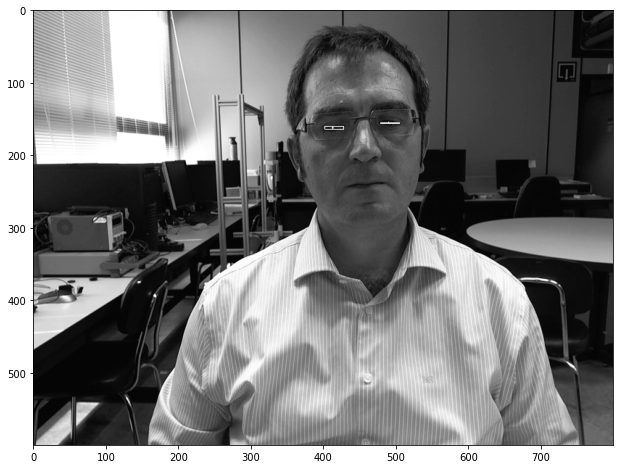

In [3]:
img_copy = img.copy()
cv2.rectangle(img_copy, (nums[0], nums[1]), (nums[4], nums[5]), (255, 0, 0), thickness=1)
cv2.circle(img_copy, (nums[2], nums[3]), 1, (255,0,0), thickness=-1)

cv2.rectangle(img_copy, (nums[6], nums[7]), (nums[10], nums[11]), (255, 0, 0), thickness=1)
cv2.circle(img_copy, (nums[8], nums[9]), 1, (255,0,0), thickness=-1)

plt.imshow(img_copy, cmap='gray');

#### Dataset preprocessing result

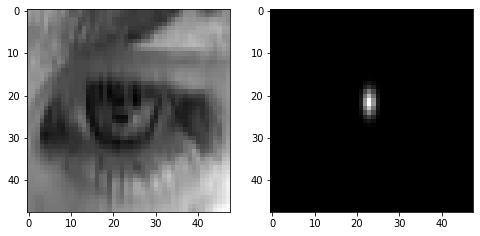

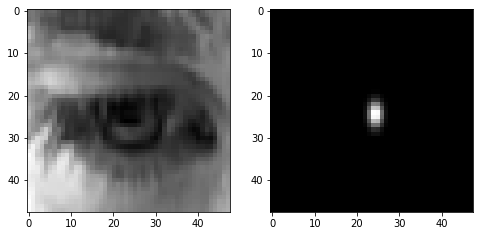

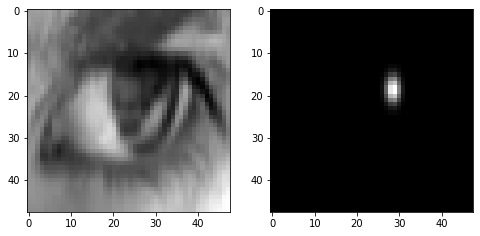

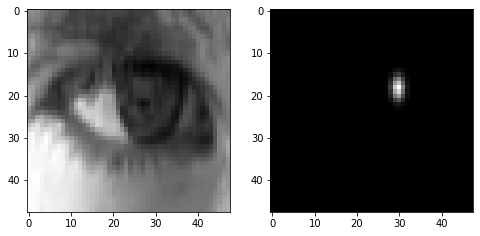

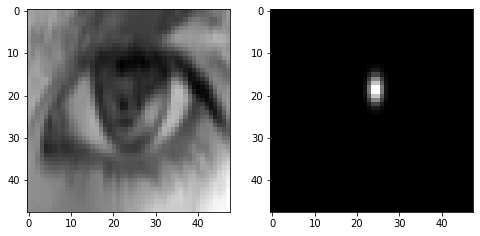

In [4]:
for i in range(5):
    fig = plt.figure(figsize=(8,4))
    fig.add_subplot(1, 2, 1)
    plt.imshow(eyes[i], cmap='gray');
    fig.add_subplot(1, 2, 2)
    plt.imshow(masks[i], cmap='gray');
    plt.show()

#### Prepare data for pyTorch model

In [5]:
import torch 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Normalization
eye_data = np.array(eyes)/255
mask_data = np.array(masks)/255

X_train, X_test, y_train, y_test = train_test_split(eye_data, mask_data, test_size=0.20, random_state=42)


batch_size = 10 

# Turn into tensors
X_train = torch.Tensor(X_train[:, None] )
X_test = torch.Tensor(X_test[:, None] )
y_train = torch.Tensor(y_train[:, None] )
y_test = torch.Tensor(y_test[:, None] )

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
train_dataloader = DataLoader(train_ds, batch_size)
test_dataloader = DataLoader(test_ds, batch_size)

### 2. Build model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, activate=F.relu):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv3 = nn.Conv2d(128, 256, 3, padding='same')
        self.batch_norm3 = torch.nn.BatchNorm2d(256)
        self.t_conv4 = nn.ConvTranspose2d(256, 64, 3, stride=5, padding=5)
        self.batch_norm4 = torch.nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(128, 64, 3, padding='same')
        self.batch_norm5 = torch.nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 1, 3, padding='same')

        self.t_conv1_aux = nn.ConvTranspose2d(256, 128, 3, padding=1)
        self.t_conv2_aux = nn.ConvTranspose2d(128, 64, 3, padding=1)
        self.t_conv3_aux = nn.ConvTranspose2d(64, 1, 3, padding=1)

        self.max_pool = nn.MaxPool2d(2, return_indices=True)
        self.max_unpool = nn.MaxUnpool2d(2)

        self.activate = activate

    def forward(self, x):
        # x.shape == (N, 1, 48, 48)
        x = self.activate(self.conv1(x))
        # x.shape == (N, 64, 48, 48)
        x_skip = x

        x, ind1 = self.max_pool(x)
        # x.shape == (N, 64, 24, 24)
        x = self.activate(self.conv2(x))
        # x.shape == (N, 128, 24, 24)

        x, ind2 = self.max_pool(x)
        # x.shape == (N, 128, 12, 12)
        x = self.activate(self.batch_norm3(self.conv3(x)))
        # x.shape == (N, 256, 12, 12)
        y = x

        x = self.activate(self.batch_norm4(self.t_conv4(x)))
        # x.shape == (N, 64, 48, 48)

        x_skip = self.batch_norm4(x_skip)
        x = torch.cat((x, x_skip), 1)
        # x.shape == (N, 128, 48, 48)

        x = self.activate(self.batch_norm5(self.conv5(x)))
        # x.shape == (N, 64, 48, 48)
        x = torch.sigmoid(self.conv6(x))
        # x.shape == (N, 1, 48, 48)

        # -----------------------------
        # Auxiliary network
        # -----------------------------
        # y.shape == (N, 256, 12, 12)
        y = self.activate(self.t_conv1_aux(y))
        # y.shape == (N, 128, 12, 12)
        y = self.max_unpool(y, ind2)
        # y.shape == (N, 128, 24, 24)

        y = self.activate(self.t_conv2_aux(y))
        # y.shape == (N, 64, 24, 24)
        y = self.max_unpool(y, ind1)
        # y.shape == (N, 64, 48, 48)

        y = torch.sigmoid(self.t_conv3_aux(y))
        # y.shape == (N, 1, 48, 48)

        return x, y


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_cnn = Net().to(device)

In [7]:
# Model summary
model_cnn

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv4): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(5, 5), padding=(5, 5))
  (batch_norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch_norm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (t_conv1_aux): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv2_aux): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv3_aux): ConvTranspose2d(64, 1, kernel_siz

#### Define train and test loops

In [8]:

def train(model, device, train_loader, optimizer, loss_function):
    model.train()
    total_loss, mask_loss, eye_loss = 0, 0, 0
    for eyes, iris_masks in train_loader:
        eyes, iris_masks = eyes.to(device), iris_masks.to(device)
        optimizer.zero_grad()
        pred_masks, pred_eyes = model(eyes)
        loss_1 = loss_function(pred_masks, iris_masks)
        loss_2 = loss_function(pred_eyes, eyes)
        loss = loss_1 + loss_2
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        mask_loss += loss_1.item()
        eye_loss += loss_2.item()
    
    total_loss /= len(train_loader)
    mask_loss /= len(train_loader)
    eye_loss /= len(train_loader)
    return total_loss, mask_loss, eye_loss


def test(model, device, test_loader, loss_function):
    model.eval()
    total_loss, mask_loss, eye_loss = 0, 0, 0
    with torch.no_grad():
        for eyes, iris_masks in test_loader:
            eyes, iris_masks = eyes.to(device), iris_masks.to(device)
            pred_masks, pred_eyes = model(eyes)
            loss_1 = loss_function(pred_masks, iris_masks)
            loss_2 = loss_function(pred_eyes, eyes)
            loss = loss_1 + loss_2

            total_loss += loss.item()
            mask_loss += loss_1.item()
            eye_loss += loss_2.item()

    total_loss /= len(test_loader)
    mask_loss /= len(test_loader)
    eye_loss /= len(test_loader)

    print('Test set: Average loss: {:.4f}'.format(total_loss))
    print('Test set: Average mask loss: {:.4f}'.format(mask_loss))
    print('Test set: Average eye image loss: {:.4f}\n'.format(eye_loss))
    return total_loss, mask_loss, eye_loss

### 3. Find best params for model

In [9]:
optimizers = [torch.optim.Adam, torch.optim.Adamax, torch.optim.RMSprop, torch.optim.SGD]
activations = [F.relu, torch.tanh, torch.sigmoid]
loss_functions = [F.mse_loss, F.l1_loss]

epochs = 20

best_error = [10, 10]
best_params = [None, None]
for opt in optimizers:
    for act in activations:
        for ind, loss_f in enumerate(loss_functions):
            print(f"Activation function: {act.__name__}, optimizer: {opt.__name__}, loss function: {loss_f.__name__}")
            model_cnn = Net(act).to(device)
            optimizer = opt(model_cnn.parameters(), lr=0.01)

            for i in range(epochs):
                train(model_cnn, device, train_dataloader, optimizer, loss_f)

            error = test(model_cnn, device, test_dataloader, loss_f)[0]
            print("Model error:", error, "\n")
            if error < best_error[ind]:
                best_error[ind] = error
                best_params[ind] = [opt, act, loss_f]

Activation function: relu, optimizer: Adam, loss function: mse_loss
Test set: Average loss: 0.1221
Test set: Average mask loss: 0.0012
Test set: Average eye image loss: 0.1209

Model error: 0.12209167137742043 

Activation function: relu, optimizer: Adam, loss function: l1_loss
Test set: Average loss: 0.3181
Test set: Average mask loss: 0.0046
Test set: Average eye image loss: 0.3135

Model error: 0.31805887520313264 

Activation function: tanh, optimizer: Adam, loss function: mse_loss
Test set: Average loss: 0.0021
Test set: Average mask loss: 0.0010
Test set: Average eye image loss: 0.0011

Model error: 0.0021358022280037405 

Activation function: tanh, optimizer: Adam, loss function: l1_loss
Test set: Average loss: 0.0224
Test set: Average mask loss: 0.0046
Test set: Average eye image loss: 0.0179

Model error: 0.02243184968829155 

Activation function: sigmoid, optimizer: Adam, loss function: mse_loss
Test set: Average loss: 0.0119
Test set: Average mask loss: 0.0013
Test set: Aver

In [10]:
for best_param in best_params:
    optimizer, activation, loss_function = best_param
    print(f"Activation function: {activation.__name__}, optimizer: {optimizer.__name__}, loss function: {loss_function.__name__}")

Activation function: relu, optimizer: Adamax, loss function: mse_loss
Activation function: tanh, optimizer: Adam, loss function: l1_loss


### 4. Train the model

In [11]:
optimizer, activation, loss_function = best_params[0]
model_cnn = Net(activation).to(device)
optimizer = optimizer(model_cnn.parameters(), lr=0.001)

epochs = 30
train_loss, test_loss = [], []
for t in range(epochs):
    print(f"Epoch {t+1}")
    train_loss.append(train(model_cnn, device, train_dataloader, optimizer, loss_function))
    test_loss.append(test(model_cnn, device, test_dataloader, loss_function))

Epoch 1
Test set: Average loss: 0.0039
Test set: Average mask loss: 0.0020
Test set: Average eye image loss: 0.0019

Epoch 2
Test set: Average loss: 0.0046
Test set: Average mask loss: 0.0025
Test set: Average eye image loss: 0.0021

Epoch 3
Test set: Average loss: 0.0035
Test set: Average mask loss: 0.0010
Test set: Average eye image loss: 0.0025

Epoch 4
Test set: Average loss: 0.0038
Test set: Average mask loss: 0.0008
Test set: Average eye image loss: 0.0029

Epoch 5
Test set: Average loss: 0.0042
Test set: Average mask loss: 0.0008
Test set: Average eye image loss: 0.0034

Epoch 6
Test set: Average loss: 0.0039
Test set: Average mask loss: 0.0006
Test set: Average eye image loss: 0.0033

Epoch 7
Test set: Average loss: 0.0034
Test set: Average mask loss: 0.0006
Test set: Average eye image loss: 0.0028

Epoch 8
Test set: Average loss: 0.0023
Test set: Average mask loss: 0.0006
Test set: Average eye image loss: 0.0017

Epoch 9
Test set: Average loss: 0.0013
Test set: Average mask lo

#### Plot losses

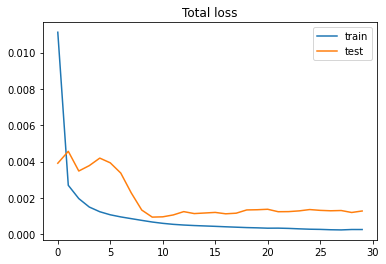

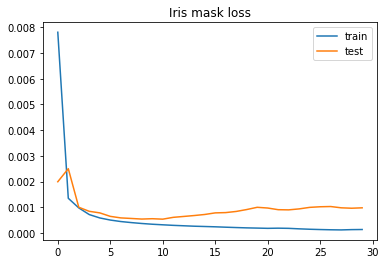

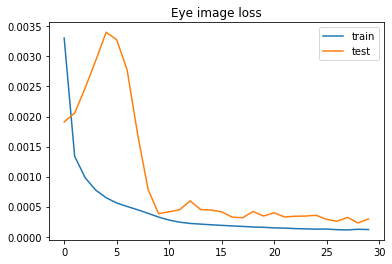

In [12]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,4))
total_train_loss = [x[0] for x in train_loss]
total_test_loss = [x[0] for x in test_loss]
plt.plot(range(epochs), total_train_loss, label='train')
plt.plot(range(epochs), total_test_loss, label='test')
plt.legend()
plt.title("Total loss")
plt.show()

plt.figure(figsize=(6,4))
mask_train_loss = [x[1] for x in train_loss]
mask_test_loss = [x[1] for x in test_loss]
plt.plot(range(epochs), mask_train_loss, label='train')
plt.plot(range(epochs), mask_test_loss, label='test')
plt.legend()
plt.title("Iris mask loss")
plt.show()

plt.figure(figsize=(6,4))
eye_train_loss = [x[2] for x in train_loss]
eye_test_loss = [x[2] for x in test_loss]
plt.plot(range(epochs), eye_train_loss, label='train')
plt.plot(range(epochs), eye_test_loss, label='test')
plt.legend()
plt.title("Eye image loss")
plt.show()

### 5. Show final results

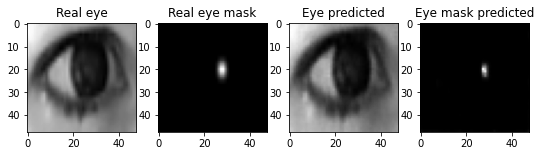

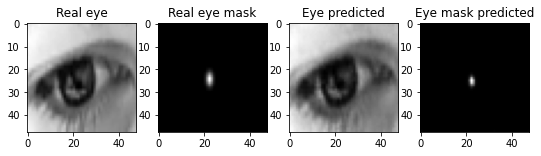

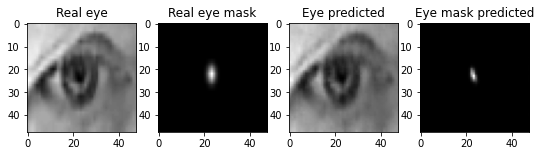

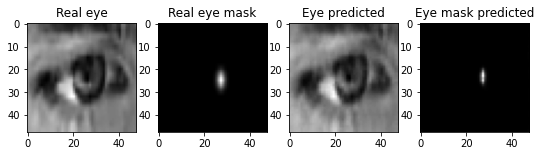

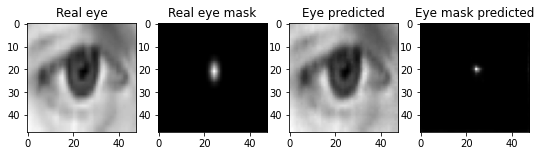

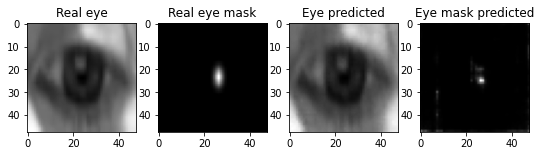

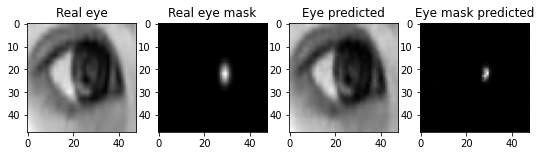

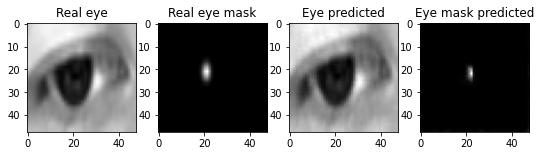

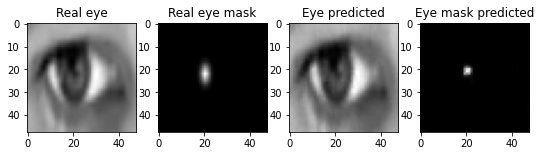

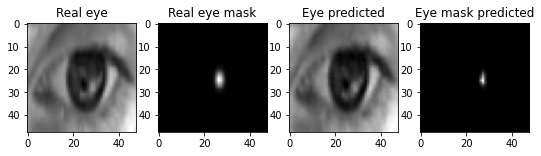

In [13]:
model_cnn.eval()
with torch.no_grad():
    data, target = next(iter(train_dataloader))
    data, target = data.to(device), target.to(device)
    mask_preds, eye_preds = model_cnn(data)
    data, target = data.cpu().detach(), target.cpu().detach()
    mask_preds, eye_preds = mask_preds.cpu().detach(), eye_preds.cpu().detach()
    for real_eye, real_mask, mask_pred, eye_pred in zip(data, target, mask_preds, eye_preds):
        fig = plt.figure(figsize=(9,4))
        fig.add_subplot(1, 4, 1)
        plt.imshow(real_eye[0], cmap='gray');
        plt.title('Real eye');

        fig.add_subplot(1, 4, 2)
        plt.imshow(real_mask[0], cmap='gray');
        plt.title('Real eye mask');

        fig.add_subplot(1, 4, 3)
        plt.imshow(eye_pred[0], cmap='gray');
        plt.title('Eye predicted');

        fig.add_subplot(1, 4, 4)
        plt.imshow(mask_pred[0], cmap='gray');
        plt.title('Eye mask predicted');

        plt.show()

# Task 4 -  Network Intrusions clustering

### 1. See the test and train data

In [14]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

pd.set_option('max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

train_data = pd.read_csv("trainset.csv")
train_data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121,tcp,-,FIN,6,4,258,172,74.087,252,254,14158.942,8495.365,0,0,24.296,8.375,30.178,11.831,255,621772692,2202533631,255,0.000,0.000,0.000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0
1,0.650,tcp,-,FIN,14,38,734,42014,78.473,62,252,8395.112,503571.312,2,17,49.915,15.433,61.427,1387.778,255,1417884146,3077387971,255,0.000,0.000,0.000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0
2,1.623,tcp,-,FIN,8,16,364,13186,14.170,62,252,1572.272,60929.230,1,6,231.876,102.737,17179.587,11420.926,255,2116150707,2963114973,255,0.112,0.061,0.050,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0
3,1.682,tcp,ftp,FIN,12,12,628,770,13.677,62,252,2740.179,3358.622,1,3,152.877,90.236,259.080,4991.785,255,1107119177,1047442890,255,0.000,0.000,0.000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0
4,0.449,tcp,-,FIN,10,6,534,268,33.374,254,252,8561.499,3987.060,2,1,47.750,75.660,2415.838,115.807,255,2436137549,1977154190,255,0.128,0.071,0.057,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0


In [15]:
test_data = pd.read_csv("testset.csv")
test_data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.000,udp,-,INT,2,0,496,0,90909.090,254,0,180363632.000,0.000,0,0,0.011,0.000,0.000,0.000,0,0,0,0,0.000,0.000,0.000,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0
1,0.000,udp,-,INT,2,0,1762,0,125000.000,254,0,881000000.000,0.000,0,0,0.008,0.000,0.000,0.000,0,0,0,0,0.000,0.000,0.000,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0
2,0.000,udp,-,INT,2,0,1068,0,200000.005,254,0,854400000.000,0.000,0,0,0.005,0.000,0.000,0.000,0,0,0,0,0.000,0.000,0.000,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0
3,0.000,udp,-,INT,2,0,900,0,166666.661,254,0,600000000.000,0.000,0,0,0.006,0.000,0.000,0.000,0,0,0,0,0.000,0.000,0.000,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0
4,0.000,udp,-,INT,2,0,2126,0,100000.003,254,0,850400000.000,0.000,0,0,0.010,0.000,0.000,0.000,0,0,0,0,0.000,0.000,0.000,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0


#### Overall information about data

In [16]:
train_data.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
count,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000,175341.000
mean,1.359,20.299,18.970,8844.844,14928.919,95406.187,179.547,79.610,73454033.194,671205.574,4.953,6.948,985.977,88.216,4976.254,604.354,116.257,969250421.911,968877027.071,115.014,0.041,0.021,0.020,136.752,124.173,0.106,2144.292,9.306,1.304,6.194,5.384,4.206,8.730,0.015,0.015,0.133,6.956,9.101,0.016
std,6.480,136.888,110.258,174765.644,143654.218,165400.978,102.940,110.507,188357447.000,2421312.389,66.005,52.733,7242.246,987.093,44965.847,4061.043,127.001,1355264249.263,1353999546.226,126.887,0.079,0.043,0.041,204.677,258.317,0.777,54207.967,10.704,0.954,8.052,8.047,5.784,10.956,0.126,0.126,0.701,8.321,10.757,0.125
min,0.000,1.000,0.000,28.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,28.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000
25%,0.000,2.000,0.000,114.000,0.000,32.786,62.000,0.000,13053.339,0.000,0.000,0.000,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,57.000,0.000,0.000,0.000,2.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,2.000,2.000,0.000
50%,0.002,2.000,2.000,430.000,164.000,3225.807,254.000,29.000,879674.750,1447.023,0.000,0.000,0.280,0.006,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,73.000,44.000,0.000,0.000,5.000,1.000,2.000,1.000,1.000,3.000,0.000,0.000,0.000,3.000,4.000,0.000
75%,0.668,12.000,10.000,1418.000,1102.000,125000.000,254.000,252.000,88888888.000,27844.871,3.000,2.000,55.157,51.053,2513.295,114.991,255.000,1916651334.000,1913674673.000,255.000,0.065,0.023,0.039,100.000,89.000,0.000,0.000,12.000,2.000,7.000,5.000,3.000,12.000,0.000,0.000,0.000,9.000,12.000,0.000
max,60.000,9616.000,10974.000,12965233.000,14655550.000,1000000.003,255.000,254.000,5988000256.000,22422730.000,4803.000,5484.000,84371.496,56716.824,1460480.016,289388.270,255.000,4294958913.000,4294881924.000,255.000,2.519,2.100,1.521,1504.000,1458.000,172.000,6558056.000,63.000,6.000,51.000,51.000,46.000,65.000,4.000,4.000,30.000,60.000,62.000,1.000


#### Plot histograms

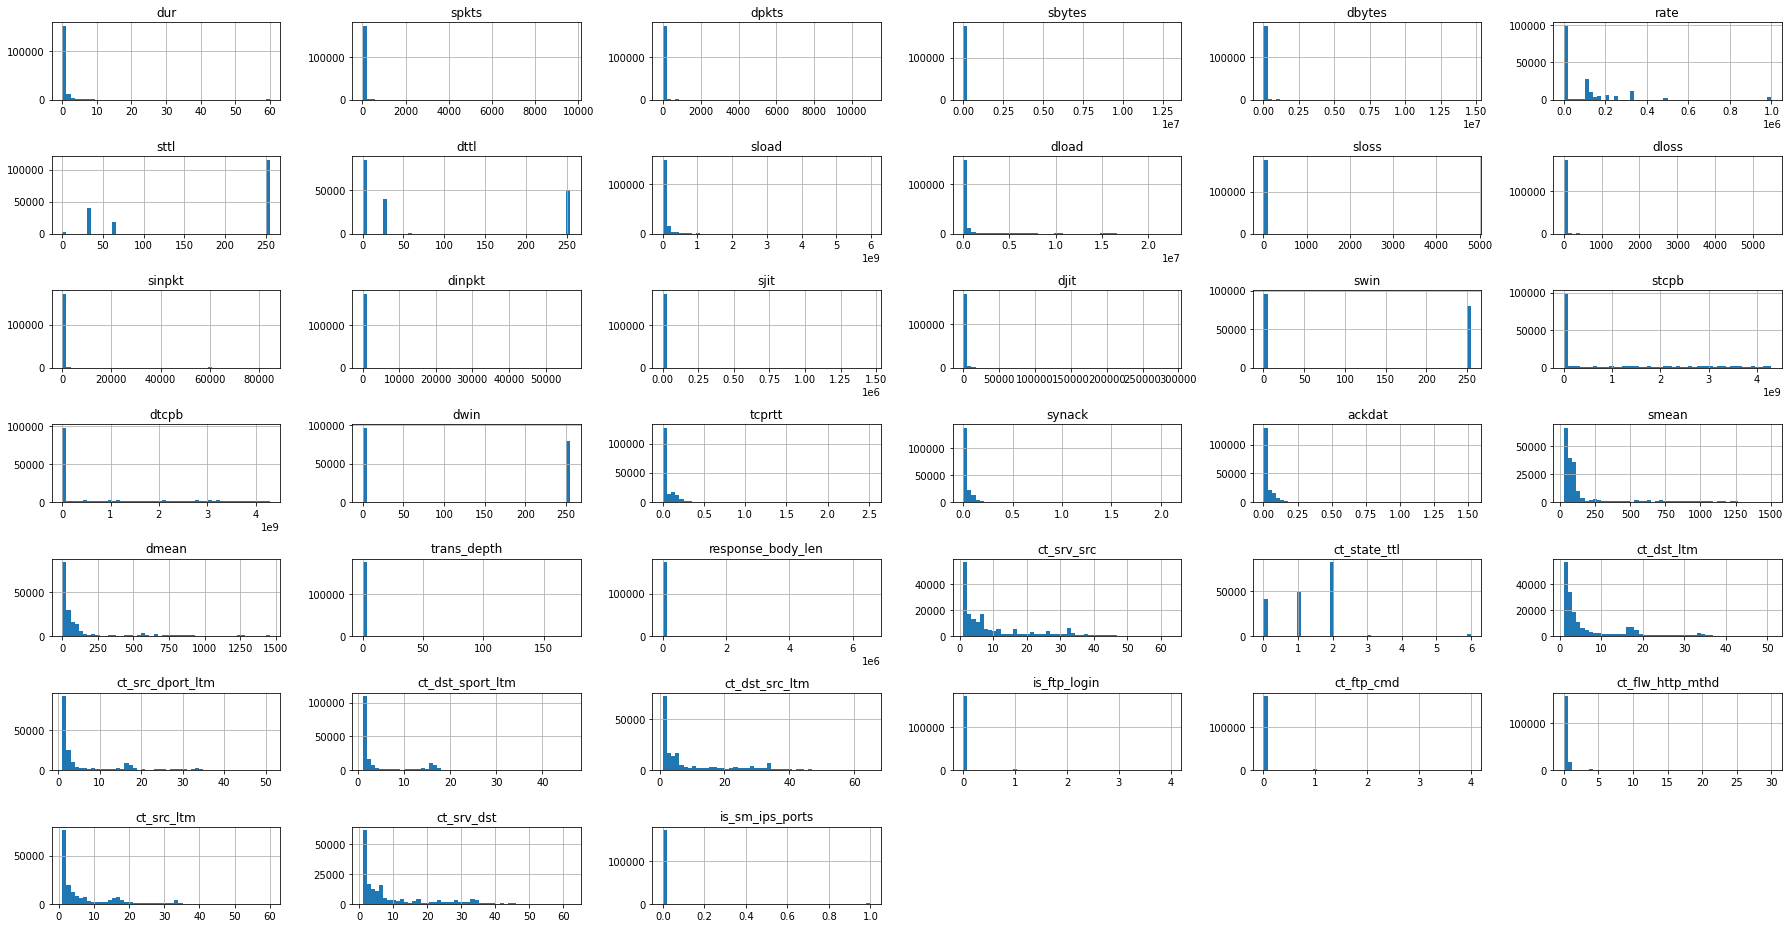

In [17]:
train_data.hist(bins = 50, figsize=(25,13));
plt.tight_layout()

#### Replace categorical features and scale dataset

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

train_data["proto"] = LabelEncoder().fit_transform(train_data["proto"])
train_data["service"] = LabelEncoder().fit_transform(train_data["service"])
train_data["state"] = LabelEncoder().fit_transform(train_data["state"])

X_scaled = MinMaxScaler().fit_transform(train_data)

### 2. Plot the data

#### 3D plot using PCA

<IPython.core.display.Javascript object>


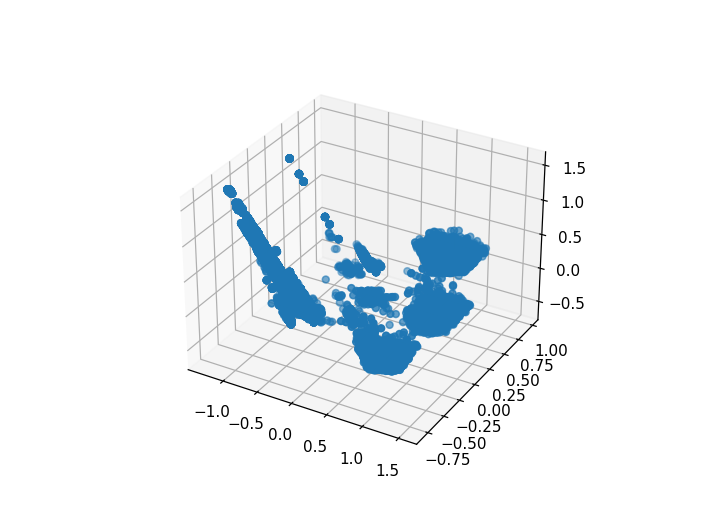

In [19]:
%matplotlib notebook
from sklearn.decomposition import PCA

X_embedded = PCA(n_components=3).fit_transform(X_scaled)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2]);
plt.show()

#### 2D plot using PCA

<IPython.core.display.Javascript object>


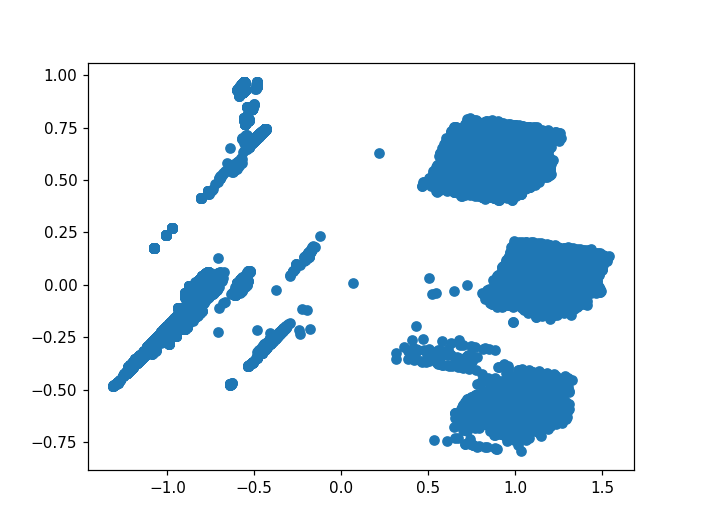

In [20]:
X_embedded = PCA(n_components=2).fit_transform(X_scaled)

fig = plt.figure()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1]);
plt.show()

### 3. Find optimal number of clusters

K=1 solved
K=2 solved
K=3 solved
K=4 solved
K=5 solved
K=6 solved
K=7 solved
K=8 solved
K=9 solved
K=10 solved


<IPython.core.display.Javascript object>


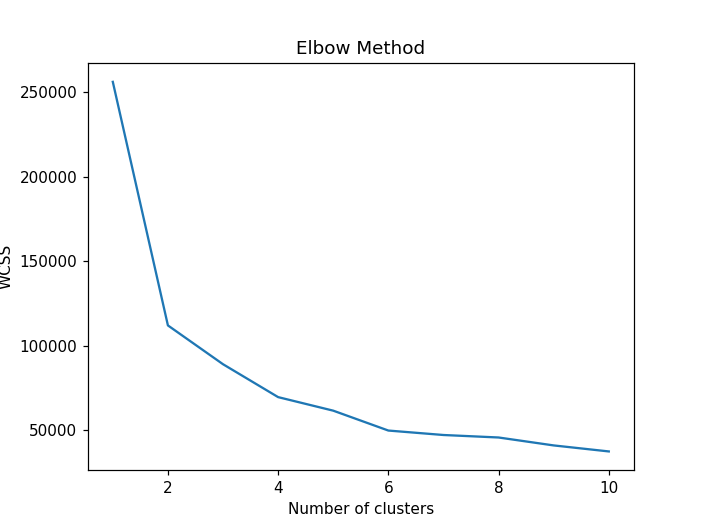

In [23]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=5, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    print(f"K={i} solved")
    
plt.figure()
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

So the optimal number of clusters is **6**

### 4. K-means++

Plot in 3D

<IPython.core.display.Javascript object>


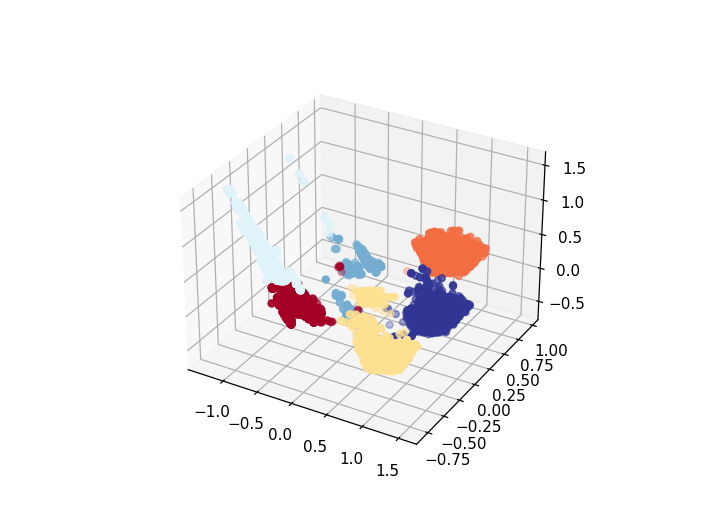

In [22]:
%matplotlib notebook

n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

X_embedded = PCA(n_components=3).fit_transform(X_scaled)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, color_i in enumerate(np.linspace(0, 1, n_clusters)):
    X = X_embedded[clusters == i]
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], color = plt.cm.RdYlBu(color_i));
plt.show();

Plot in 2D

<IPython.core.display.Javascript object>


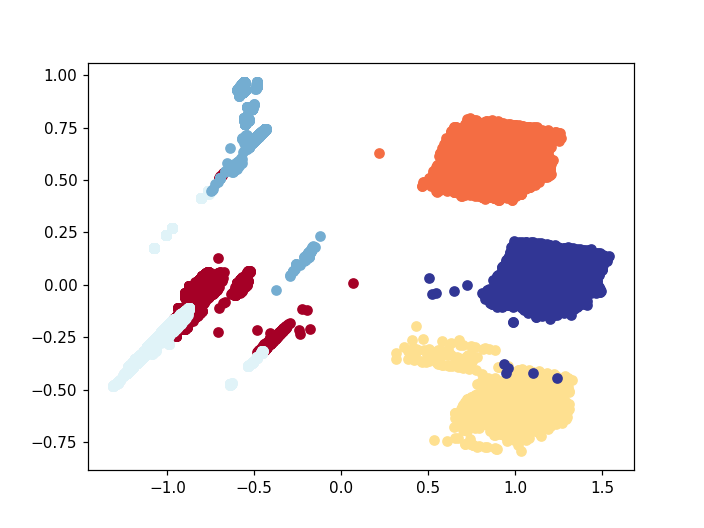

In [24]:
X_embedded = PCA(n_components=2).fit_transform(X_scaled)

fig = plt.figure()
for i, color_i in enumerate(np.linspace(0, 1, n_clusters)):
    X = X_embedded[clusters == i]
    plt.scatter(X[:, 0], X[:, 1], color = plt.cm.RdYlBu(color_i));
plt.show()

  There are other clustering methods such as agglomerative clustering, Spectral Clustering and so on. But you need a lot of RAM, because we have 100 000 entries.  
  DBSCAN should be quite good also. It leaves outliers, but we need to cluster all the data, so it's not suitable for us.  
  Let's try BIRCH clustering algorithm

### 5. BIRCH

<IPython.core.display.Javascript object>


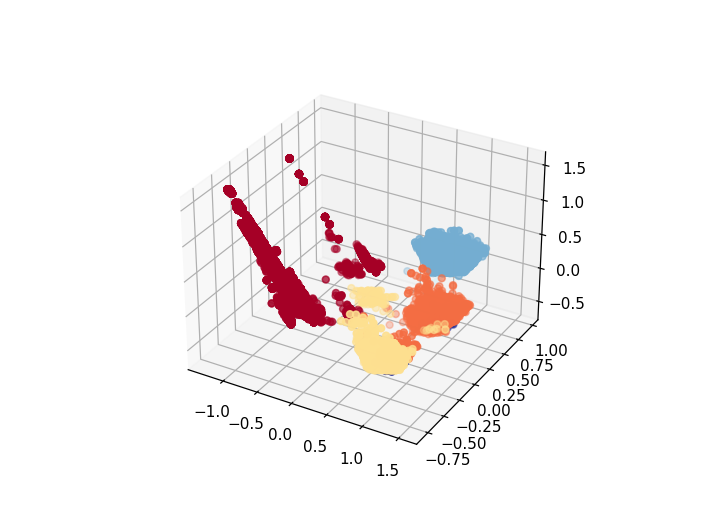

In [25]:
%matplotlib notebook

from sklearn.cluster import Birch
birch = Birch(n_clusters=n_clusters)
clusters = birch.fit_predict(X_scaled)

X_embedded = PCA(n_components=3).fit_transform(X_scaled)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, color_i in enumerate(np.linspace(0, 1, n_clusters)):
    X = X_embedded[clusters == i]
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], color = plt.cm.RdYlBu(color_i))
plt.show();

<IPython.core.display.Javascript object>


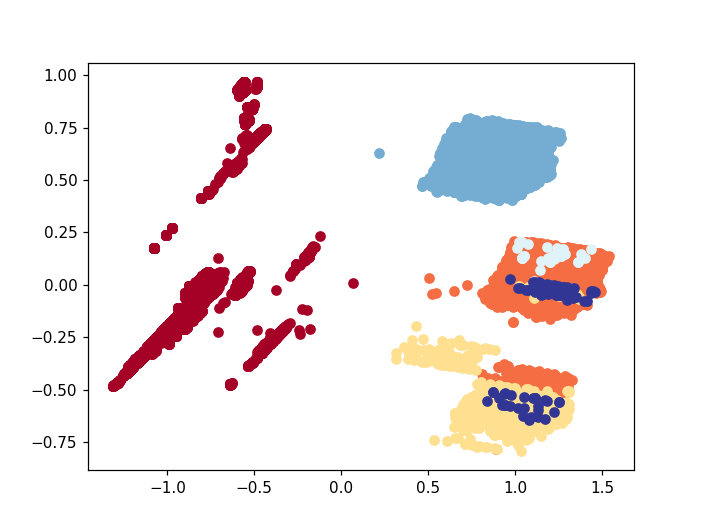

In [26]:
X_embedded = PCA(n_components=2).fit_transform(X_scaled)

fig = plt.figure()
for i, color_i in enumerate(np.linspace(0, 1, n_clusters)):
    X = X_embedded[clusters == i]
    plt.scatter(X[:, 0], X[:, 1], color = plt.cm.RdYlBu(color_i));
plt.show()

BIRCH gives worse results than K-means. So in our case K-means one of the best clustering algorithm

### 6. Preprocess and plot test data

In [27]:
from sklearn.preprocessing import LabelEncoder

test_data["proto"] = LabelEncoder().fit_transform(test_data["proto"])
test_data["service"] = LabelEncoder().fit_transform(test_data["service"])
test_data["state"] = LabelEncoder().fit_transform(test_data["state"])

X_scaled = MinMaxScaler().fit_transform(test_data)

<IPython.core.display.Javascript object>


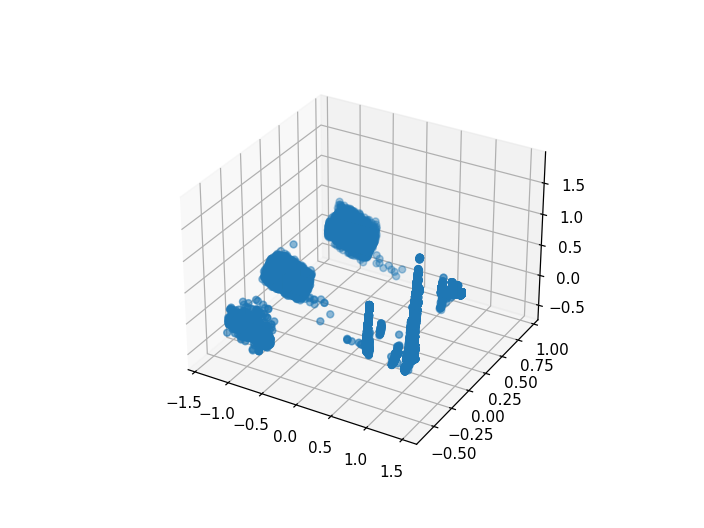

In [28]:
X_embedded = PCA(n_components=3).fit_transform(X_scaled)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2])
plt.show()

### 7. Find test data clusters

<IPython.core.display.Javascript object>


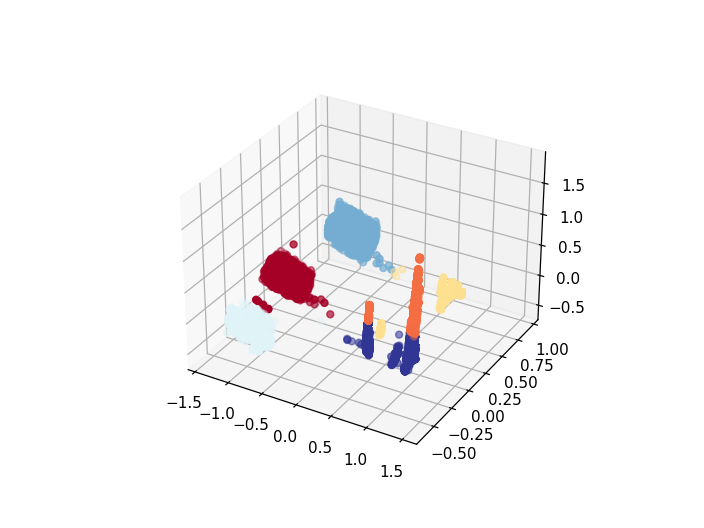

In [29]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

X_embedded = PCA(n_components=3).fit_transform(X_scaled)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, color_i in enumerate(np.linspace(0, 1, n_clusters)):
    X = X_embedded[clusters == i]
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], color = plt.cm.RdYlBu(color_i));
plt.show();

<IPython.core.display.Javascript object>


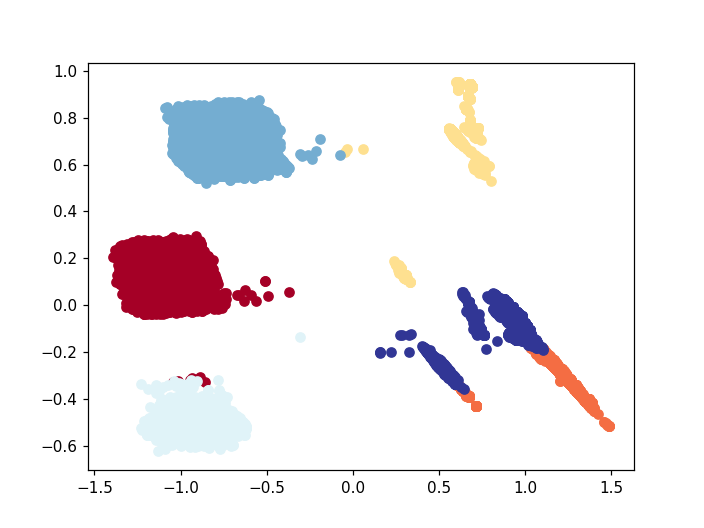

In [30]:
X_embedded = PCA(n_components=2).fit_transform(X_scaled)

fig = plt.figure()
for i, color_i in enumerate(np.linspace(0, 1, n_clusters)):
    X = X_embedded[clusters == i]
    plt.scatter(X[:, 0], X[:, 1], color = plt.cm.RdYlBu(color_i));
plt.show()

So we clearly find clusters of network intrusions.

# Task 5 -   Design Patterns Detection

### 1. Read data and extract features

In [31]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from tqdm import tqdm

def read_data(is_train=True):
    folder = 'Dp_trainset' if is_train else 'Dp_testset'
    imputer = SimpleImputer(strategy='median')
    
    #Just read the first project to extract information about files (get columns)
    for pattern_type in os.listdir(folder):
        pattern_folder = os.path.join(folder, pattern_type)
        for project in os.listdir(pattern_folder):
            project_folder = os.path.join(pattern_folder, project, 'ckmetrics')
            class_csv = pd.read_csv(os.path.join(project_folder, 'class.csv'))
            method_csv = pd.read_csv(os.path.join(project_folder, 'method.csv'))
            variable_csv = pd.read_csv(os.path.join(project_folder, 'variable.csv'))
            break
        break 
    
    #Get features from files
    class_csv_features = class_csv.agg(['sum', 'min', 'median', 'mean', 'std', 'max']).iloc[:,3:]
    method_csv_features = method_csv.agg(['sum', 'min', 'median', 'mean', 'std', 'max']).iloc[:,3:]
    variable_csv_features = variable_csv.agg(['sum', 'min', 'median', 'mean', 'std', 'max']).iloc[:,4:]

    columns = ['class_csv_' + c + '_' + i for i in class_csv_features.index for c in class_csv_features.columns]
    columns += ['method_csv_' + c + '_' + i for i in method_csv_features.index for c in method_csv_features.columns]
    columns += ['variable_csv_' + c + '_' + i for i in variable_csv_features.index for c in variable_csv_features.columns]
    columns += ['class_num', 'class_csv_count', 'file_num', 'pattern_type']
    data = pd.DataFrame(columns=columns)

    for pattern_type in tqdm(os.listdir(folder)):
        pattern_folder = os.path.join(folder, pattern_type)
        for project in os.listdir(pattern_folder):
            project_folder = os.path.join(pattern_folder, project, 'ckmetrics')
            class_csv = pd.read_csv(os.path.join(project_folder, 'class.csv'))
            method_csv = pd.read_csv(os.path.join(project_folder, 'method.csv'))
            variable_csv = pd.read_csv(os.path.join(project_folder, 'variable.csv'))

            if len(class_csv):
                # Remove nans in data
                tcc = imputer.fit_transform(class_csv['tcc'].values.reshape(-1, 1))
                lcc = imputer.fit_transform(class_csv['lcc'].values.reshape(-1, 1))
                class_csv['tcc'] = tcc if tcc.shape[1] else 0        
                class_csv['lcc'] = lcc if lcc.shape[1] else 0 
                
                # Get features
                class_csv_features = class_csv.agg(['sum', 'min', 'median', 'mean', 'std', 'max']).iloc[:,3:]
                method_csv_features = method_csv.agg(['sum', 'min', 'median', 'mean', 'std', 'max']).iloc[:,3:]
                variable_csv_features = variable_csv.agg(['sum', 'min', 'median', 'mean', 'std', 'max']).iloc[:,4:]
                
                # Remove nans
                imputer = SimpleImputer(strategy='constant', fill_value = 0)
                class_csv_features = imputer.fit_transform(class_csv_features)
                method_csv_features = imputer.fit_transform(method_csv_features)
                variable_csv_features = imputer.fit_transform(variable_csv_features)
                
                # Get some extra features
                class_num = sum(class_csv['type'] == 'class')
                class_csv_count = len(class_csv)
                file_num = len(set(class_csv['file']))
                
                # Concatenate everything together
                features = class_csv_features.ravel()
                features = np.append(features, method_csv_features.ravel())
                features = np.append(features, variable_csv_features.ravel())
                features = np.append(features, [class_num, class_csv_count, file_num, pattern_type])
                
                # Add data entry
                data.loc[len(data)] = features
    return data

train_data = read_data()
test_data = read_data(is_train=False)

print("Number of features:", train_data.shape[1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:11<00:00,  2.08it/s]

Number of features: 442


#### Functions to get category from design pattern type 

In [32]:
categories = {'Creational': ['Abstract_factory', 'Builder', 'Factory', 'Prototype', 'Singleton'],
 'Behavioral': ['Chain_of_responsibility', 'Command', 'Interpreter', 'Iterator', 'Mediator', 'Memento', 'Observer', 'State', 
    'Strategy', 'Template', 'Visitor'],
 'Structural': ['Adapter', 'Bridge', 'Composite', 'Decorator', 'Facade', 'Flyweight', 'Proxy']}

def get_category(x):
    for k in categories.keys():
        if x in categories[k]:
            return k     

#### Scale data

In [33]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train = train_data.drop(columns=['pattern_type'])
y_train = train_data['pattern_type']
X_train[:] = std_scaler.fit_transform(X_train)

X_test = test_data.drop(columns=['pattern_type'])
y_test = test_data['pattern_type']
X_test[:] = std_scaler.transform(X_test)


### 2. Initial predict on decision tree


In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)
base_accuracy = accuracy_score(y_test.apply(get_category), list(map(get_category, dt.predict(X_test))))
print('Accuracy: {:.2f}%'.format(base_accuracy*100))

Accuracy: 48.67%


### 3. Get best features

So if we remove feature and the accuracy of the test data decreases, then this feature is important.

In [35]:
col = []
for c in X_train.columns:
    X = X_train.drop(columns=[c])
    dt.fit(X, y_train)
    score = accuracy_score(y_test.apply(get_category), list(map(get_category, dt.predict(X_test.drop(columns=[c])))))
    if score <= base_accuracy:
        col.append(c)
print('Number of features:', len(col))

X_train_best_features = X_train[col]
X_test_best_features = X_test[col]

Number of features: 330


### 2. Predict design pattern type
#### 2.1 Decision tree

In [36]:
dt = DecisionTreeClassifier(random_state=2)
dt.fit(X_train_best_features, y_train)
acc = accuracy_score(y_test.apply(get_category), list(map(get_category, dt.predict(X_test_best_features))))
print('Accuracy on test data: {:.2f}%'.format(acc*100))

Accuracy on test data: 53.10%


So results are improved

#### 2.2 K-nearest neighbors classifier

In [37]:
from sklearn.neighbors import KNeighborsClassifier

best_score = 0
n = None
for i in range(2, 10):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_best_features, y_train)
    acc = accuracy_score(y_test.apply(get_category), list(map(get_category, knn.predict(X_test_best_features))))
    if best_score < acc:
        best_score = acc
        n = i
print('Best accuracy on test data: {:.2f}% with {} neighbors.'.format(acc*100, n))

Best accuracy on test data: 52.21% with 8 neighbors.


#### 2.3 Random forests

Random forests are an ensemble learning method for classification. It uses decision tree with bagging inside. 

**Find the best parameters using GridSearchCV**

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier()
params = {'n_estimators': np.logspace(1, 3, 20).astype('int'), 'max_features': ['auto', 'sqrt', 'log2'], 
         'min_impurity_decrease': np.arange(0, 0.3, 0.1)}

gridCV = GridSearchCV(estimator = estimator, param_grid = params, scoring='accuracy', 
                      cv = 2, n_jobs=-1, verbose=5, return_train_score=True)
gridCV.fit(X_train_best_features, y_train)

Fitting 2 folds for each of 180 candidates, totalling 360 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_impurity_decrease': array([0. , 0.1, 0.2]),
                         'n_estimators': array([  10,   12,   16,   20,   26,   33,   42,   54,   69,   88,  112,
        143,  183,  233,  297,  379,  483,  615,  784, 1000])},
             return_train_score=True, scoring='accuracy', verbose=5)

In [39]:
print("Best features:", gridCV.best_params_)
acc = accuracy_score(y_test.apply(get_category), list(map(get_category, gridCV.predict(X_test_best_features))))
print('Accuracy on test data: {:.2f}%'.format(acc*100))

Best features: {'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'n_estimators': 112}
Accuracy on test data: 38.94%


#### 2.4 AdaBoost

This is boosting algorithm. We are going to use decision tree as a base estimator.

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

estimator = AdaBoostClassifier(DecisionTreeClassifier())
params = {'n_estimators': np.logspace(1, 3, 20).astype('int')}

gridCV = GridSearchCV(estimator = estimator, param_grid = params, scoring='accuracy', 
                      cv = 2, n_jobs=-1, verbose=5, return_train_score=True)
gridCV.fit(X_train_best_features, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


GridSearchCV(cv=2,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'n_estimators': array([  10,   12,   16,   20,   26,   33,   42,   54,   69,   88,  112,
        143,  183,  233,  297,  379,  483,  615,  784, 1000])},
             return_train_score=True, scoring='accuracy', verbose=5)

In [41]:
print("Best features:", gridCV.best_params_)
acc = accuracy_score(y_test.apply(get_category), list(map(get_category, gridCV.predict(X_test_best_features))))
print('Accuracy on test data: {:.2f}%'.format(acc*100))

Best features: {'n_estimators': 784}
Accuracy on test data: 38.05%


So in our case simple decision tree gives the best results.  
Ensemble algorithms are not so good in our case. It maybe happen because of bad data. 